## Importing the Relevant Files (all necessary packages are included in each file)

In [1]:
import sys
sys.path.insert(0, 'price_action_strategies')
sys.path.insert(0, 'price_action_strategies/IHS&HS')
from find_extrema_file import *
from backtester import *
from head_and_shoulders import *
from data_formatting import *

## Head and Shoulders Strategy

In [2]:
class Head_and_Shoulders(Backtest_Environment):
    
    # first line of arguments contains strategy specific parameters, second line contains backtest environment parameters
    def __init__(self, data, start_date, end_date,
                 start_cash, pos_size, tc, cooldown=1, 
                 max_executions=None, max_execution_period=None, cash_buffer=0, stoploss=None, trailing_stoploss=False, 
                 custom_stoploss=False, add_open_noise=False):
        """
        Generic:
        Constructor method for the strategy child class. Extra arguments specific to the child can be added to this 
        constructor.
        
        The benefit of this is that, strategy specific parameters can be added to this class with the data preparation 
        methods occurring within the class prior to backtest(). 
        
        This structure allows for an easier defintion of new strategies for strategies with the similar rule structures
        but different parameters applied to those rules. 
        
        Head and Shoulders:
        - custom_stoploss is equal to True. The stoploss is set via the HEAD of the strategy in the data prepration
        section of the code above. 
        """
        
        # Calling the constructor of the parent class - stores input variables + adds strategy agnostic columns to the data
        super().__init__(data, start_cash, pos_size, tc, cooldown, max_executions, max_execution_period, cash_buffer, stoploss, 
                         trailing_stoploss, custom_stoploss, add_open_noise)

        # Strategy specific parameters
        self.start_date = start_date
        self.end_date = end_date
        
    
    def process(self, data):
        """
        Enter Logic:
        - Enter when Entry is equal to 1
        
        Returns:
        - number of units and order type: Short
        - if entry logic not met, returns 0
        """
    
        if data.Entry.values[0] == 1:
            num_units = int(np.floor((self.pos_size * self.cash_available) / data.Close.values[0]))

            if num_units == 0:
                        return 0

             # cash check - acts as a lid on opening new positions
            if (self.cash_available - num_units*data.Close.values[0]) > self.cash_buffer:
                
                return num_units, "Short"

            else:
                return 0

        return 0


    def monitorPosition(self, data, position):
        """
        Exit logic: 
        - When current close is less than or equal to the position target (set by the pos_target variable in the data 
        preparation section in the example Notebook) or;
        - when the current close or current high closes ABOVE the stoploss (since it is a bearish strategy)
        - an additional condition (the second condition of the AND) is added so that positions are not exited on the same day
        as they are entered. This is because the current day's high could be higher than the stoploss set by the strategy.
        """
    
        if data.Close.values[0] <= position.PosTarget.values[0]:

            return True

        elif data.Close.values[0] >= position.StopLoss.values[0] or (data.High.values[0] >= position.StopLoss.values[0] and data.index != position.EntryDate - timedelta(days=1)):

            return True

        else:

            return False

## Data Preparation Section of Notebook

In [3]:
stock = yf.Ticker("MFA").history(period="5y")
max_bars = 35
signal_type = "bearish"
pos_target = 0.05

detection_dates, price_points, entry_points, entry_dates, stoploss, opper = format_strategy_data(stock, head_and_shoulders, max_bars, signal_type)
stock = create_strategy_df(stock, detection_dates, entry_dates, stoploss, pos_target, opper)

In [4]:
stock[stock["Entry"] == 1]

,Open,High,Low,Close,Volume,PatternDetected,Entry,StopLoss,PosTarget
Date,,,,,,,,,
2016-12-15,4.398031,4.409544,4.334709,4.351978,2229300,0,1,4.518919,4.161723
2017-02-17,4.748044,4.753950,4.694894,4.712611,1791100,1,1,4.759855,4.499422
2017-12-12,5.093528,5.106214,5.036440,5.049126,2286300,0,1,5.195017,4.796669
2018-01-09,5.052909,5.065915,5.000885,5.000885,1830300,0,1,5.215488,4.726129
2018-01-25,4.942357,4.942357,4.812295,4.877326,3049300,1,1,5.072419,4.639637
2018-09-24,5.233530,5.247248,5.171797,5.192375,2433700,1,1,5.363853,4.932756
2019-02-28,5.291818,5.313596,5.262782,5.277300,1774100,0,1,5.415222,5.027227
2019-05-07,5.552409,5.574797,5.455391,5.455391,2783900,1,1,5.604648,5.203891
2019-07-31,5.579673,5.595023,5.495249,5.510599,2843500,0,1,5.579673,5.242361


## Instantiating the Strategy Class

## Running the Strategy

In [5]:
strat = Head_and_Shoulders(stock, stock.index[0], stock.index[-1],
                         start_cash=1000, pos_size=1, tc=0.005, cooldown=0, 
                         max_executions=None, max_execution_period=None, cash_buffer=0, custom_stoploss=True,
                           add_open_noise=False)
strat.backtest()

True

## Strategy Performance

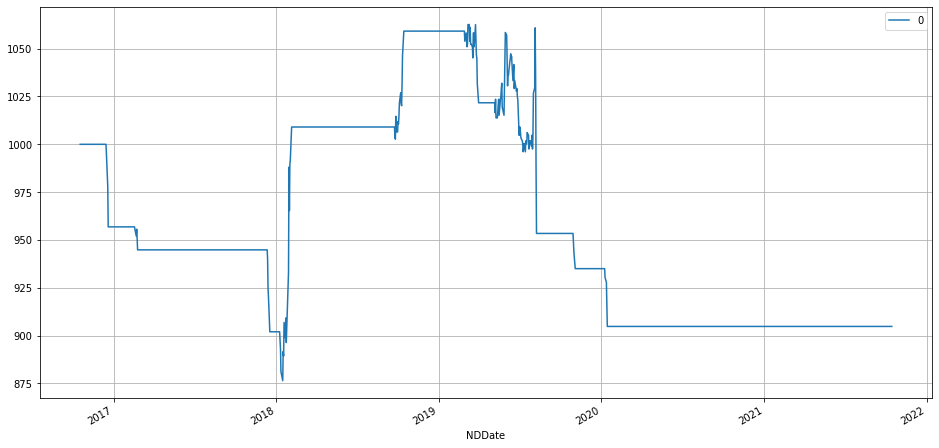

,Status,PosType,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss,Max DD Value,Max DD Return,Holding Time
0,False,Short,42,229,4.380762,2016-12-16,4.161723,4.518919,1003.194387,4.524676,2016-12-20,-32.956460,-0.032852,-1.0,0.068,-0.016,4
0,False,Short,85,203,4.736233,2017-02-21,4.499422,4.759855,961.455347,4.748044,2017-02-24,-2.397588,-0.002494,-1.0,0.030,-0.006,3
0,False,Short,291,187,5.049125,2017-12-13,4.796669,5.195017,944.186416,5.226733,2017-12-18,-33.212608,-0.035176,-1.0,0.094,-0.018,5
0,False,Short,309,180,4.974873,2018-01-10,4.726129,5.215488,895.477103,4.656220,2018-01-30,57.357429,0.064052,1.0,0.091,-0.018,20
0,False,Short,320,184,4.883829,2018-01-26,4.639637,5.072419,898.624511,4.519655,2018-02-05,67.008061,0.074567,1.0,0.136,-0.027,10
0,False,Short,487,194,5.192375,2018-09-25,4.932756,5.363853,1007.320693,4.883618,2018-10-15,59.898804,0.059463,1.0,0.043,-0.008,20
0,False,Short,594,200,5.291818,2019-03-01,5.027227,5.415222,1058.363673,5.425539,2019-04-01,-26.744148,-0.025269,-1.0,0.178,-0.033,31
0,False,Short,641,187,5.477780,2019-05-08,5.203891,5.604648,1024.344829,5.702473,2019-08-09,-42.017576,-0.041019,-1.0,0.470,-0.082,93
0,False,Short,700,184,5.518274,2019-08-01,5.242361,5.579673,1015.362457,5.548974,2019-08-08,-5.648806,-0.005563,-1.0,0.192,-0.034,7
0,False,Short,764,160,5.959064,2019-10-31,5.661111,5.990594,953.450251,6.014241,2019-11-04,-8.828256,-0.009259,-1.0,0.023,-0.004,4


,0
Initial Capital,1000.000000
Ending Capital,904.795756
Total Profit,-95.204244
Total Profit Percentage,-0.095204
Exposure,0.100000
Annual Return,-0.019842
Annual Sharpe Ratio,-0.294000
Annual Sortino Ratio,-0.148000
Transaction Costs,106.910252
Portfolio Max DD Value,157.797000


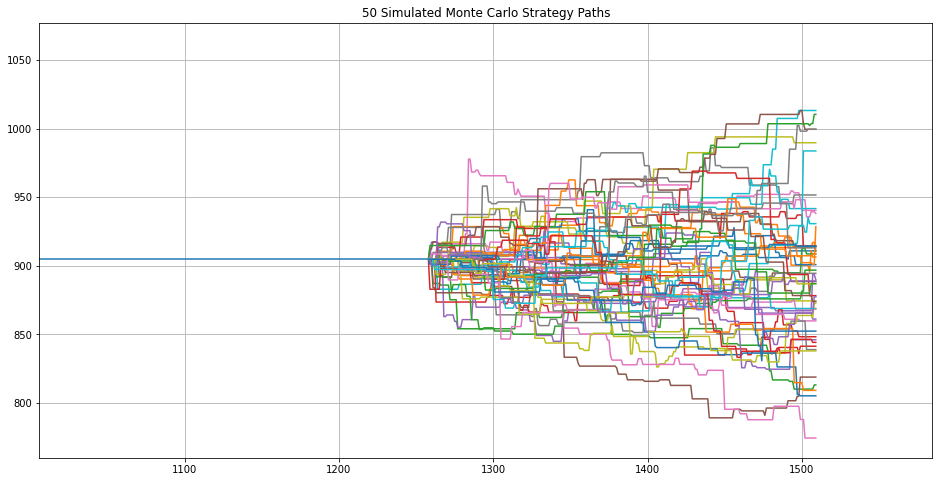

In [6]:
strat.portfolio_time_series.plot(figsize=(16,8))
plt.grid()
plt.show()
display(strat.positions)
display(strat.stats.T)
strat.plot_MC(N=50, days_to_simulate=252, pos_ret_q=0)